Import Dataset from kaggle

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download divg07/casia-20-image-tampering-detection-dataset

Dataset URL: https://www.kaggle.com/datasets/divg07/casia-20-image-tampering-detection-dataset
License(s): unknown
 99% 2.54G/2.56G [00:18<00:00, 237MB/s]
100% 2.56G/2.56G [00:18<00:00, 150MB/s]


In [3]:
import zipfile
zip_ref=zipfile.ZipFile('/content/casia-20-image-tampering-detection-dataset.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

Data Preprocessing

In [4]:
import os
import cv2
from tqdm import tqdm

# Define paths for the dataset
base_dir = "/content/CASIA2"  # Base directory containing the dataset
authentic_dir = os.path.join(base_dir, "Au")  # Directory for authentic/untampered images
tampered_dir = os.path.join(base_dir, "Tp")  # Directory for tampered/forged images
groundtruth_dir = os.path.join(base_dir, "CASIA 2 Groundtruth")  # Directory for ground truth masks

# Directory to store preprocessed data
preprocessed_dir = "/content/CASIA2_preprocessed"
os.makedirs(preprocessed_dir, exist_ok=True)  # Create the base preprocessed directory if it doesn't exist

# Subdirectories for storing preprocessed authentic images, tampered images, and masks
authentic_out_dir = os.path.join(preprocessed_dir, "authentic")
tampered_out_dir = os.path.join(preprocessed_dir, "tampered")
masks_out_dir = os.path.join(preprocessed_dir, "masks")

# Create subdirectories if they don't already exist
for folder in [authentic_out_dir, tampered_out_dir, masks_out_dir]:
    os.makedirs(folder, exist_ok=True)

# Function to preprocess images or masks
def preprocess_images(input_dir, output_dir, size=(512, 512), is_mask=False):
    """
    Preprocess images by resizing and optionally thresholding masks.

    Args:
        input_dir (str): Directory containing input images.
        output_dir (str): Directory to save preprocessed images.
        size (tuple): Target size for resizing (width, height).
        is_mask (bool): Whether the input is a binary mask (default: False).
    """
    for img_name in tqdm(os.listdir(input_dir), desc=f"Processing {input_dir}"):
        img_path = os.path.join(input_dir, img_name)  # Full path to the input image
        # Read the image (grayscale for masks, color for regular images)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE if is_mask else cv2.IMREAD_COLOR)
        if img is None:  # Skip if the image cannot be read
            print(f"Warning: Could not read {img_path}")
            continue
        # Resize the image to the specified size
        img_resized = cv2.resize(img, size)
        if is_mask:  # If processing masks, ensure binary format
            _, img_resized = cv2.threshold(img_resized, 127, 255, cv2.THRESH_BINARY)
        # Save the preprocessed image to the output directory
        output_path = os.path.join(output_dir, img_name)
        cv2.imwrite(output_path, img_resized)

# # Preprocess authentic images
# preprocess_images(authentic_dir, authentic_out_dir)

# Preprocess tampered/forged images
preprocess_images(tampered_dir, tampered_out_dir)

# Preprocess ground truth masks
preprocess_images(groundtruth_dir, masks_out_dir, is_mask=True)


Processing /content/CASIA2/Tp:  63%|██████▎   | 3233/5125 [00:37<00:28, 66.83it/s]

Processing /content/CASIA2/Tp:  96%|█████████▌| 4904/5125 [00:56<00:02, 90.13it/s] 

Processing /content/CASIA2/CASIA 2 Groundtruth: 100%|██████████| 5123/5123 [00:18<00:00, 283.60it/s]


Data Visualization

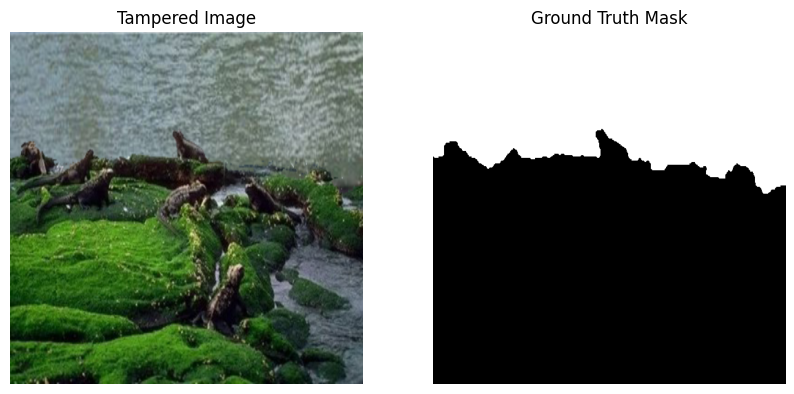

In [5]:
import os
import cv2
import matplotlib.pyplot as plt

def find_corresponding_mask(image_name, mask_dir):
    """
    Finds the corresponding mask file for a given tampered image based on the naming convention.
    """
    base_name = os.path.splitext(image_name)[0]  # Get the base name without extension
    mask_name = f"{base_name}_gt"  # Append '_gt' to match the ground truth mask
    for mask_file in os.listdir(mask_dir):
        if os.path.splitext(mask_file)[0] == mask_name:  # Match the base name with '_gt'
            return os.path.join(mask_dir, mask_file)
    return None  # Return None if no matching mask is found

def show_sample(image_dir, mask_dir, image_name):
    """
    Displays a tampered image and its corresponding ground truth mask.
    """
    image_path = os.path.join(image_dir, image_name)
    mask_path = find_corresponding_mask(image_name, mask_dir)

    if mask_path is None:
        print(f"Mask not found for {image_name}")
        return

    # Load image and mask
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Plot the tampered image and mask
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Tampered Image")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Ground Truth Mask")
    plt.imshow(mask, cmap="gray")
    plt.axis("off")

    plt.show()

# Example usage
tampered_dir = "/content/CASIA2_preprocessed/tampered"
mask_dir = "/content/CASIA2_preprocessed/masks"

# Replace 'example.jpg' with an actual filename from your tampered images folder
sample_image_name = "Tp_D_CND_M_N_ani00018_sec00096_00138.tif"  # Adjust this to match one of your image names
show_sample(tampered_dir, mask_dir, sample_image_name)


Storing the Dataset info in a Dataframe

In [6]:
import os
import pandas as pd

# Directories
tampered_dir = "/content/CASIA2_preprocessed/tampered"
masks_dir = "/content/CASIA2_preprocessed/masks"

# Function to extract base name (without extension)
def get_base_name(file_name):
    return os.path.splitext(file_name)[0]

# Get file names and paths
tampered_files = os.listdir(tampered_dir)
tampered_paths = [os.path.join(tampered_dir, f) for f in tampered_files]
mask_files = os.listdir(masks_dir)
mask_paths = [os.path.join(masks_dir, f) for f in mask_files]

# Map tampered images to their corresponding ground truth masks
mapped_data = []
for tampered_file, tampered_path in zip(tampered_files, tampered_paths):
    tampered_base = get_base_name(tampered_file)
    corresponding_mask_file = f"{tampered_base}_gt"

    for mask_file, mask_path in zip(mask_files, mask_paths):
        if get_base_name(mask_file) == corresponding_mask_file:
            mapped_data.append({
                "tampered_image_file_name": tampered_file,
                "tampered_image_file_path": tampered_path,
                "groundtruth_image_file_name": mask_file,
                "groundtruth_image_file_path": mask_path
            })
            break

# Create DataFrame
df = pd.DataFrame(mapped_data)

# Display first few rows of the DataFrame
df.head()


tampered_image_file_name  \
0  Tp_S_NRN_S_N_cha10132_cha10132_12216.jpg   
1  Tp_D_NRN_S_N_nat00033_ani00017_11507.jpg   
2  Tp_S_NNN_S_N_ani10194_ani10194_12399.jpg   
3  Tp_S_NNN_S_N_pla20087_pla20087_02490.tif   
4  Tp_D_NNN_M_N_art00099_cha00050_11760.jpg   

                            tampered_image_file_path  \
0  /content/CASIA2_preprocessed/tampered/Tp_S_NRN...   
1  /content/CASIA2_preprocessed/tampered/Tp_D_NRN...   
2  /content/CASIA2_preprocessed/tampered/Tp_S_NNN...   
3  /content/CASIA2_preprocessed/tampered/Tp_S_NNN...   
4  /content/CASIA2_preprocessed/tampered/Tp_D_NNN...   

                   groundtruth_image_file_name  \
0  Tp_S_NRN_S_N_cha10132_cha10132_12216_gt.png   
1  Tp_D_NRN_S_N_nat00033_ani00017_11507_gt.png   
2  Tp_S_NNN_S_N_ani10194_ani10194_12399_gt.png   
3  Tp_S_NNN_S_N_pla20087_pla20087_02490_gt.png   
4  Tp_D_NNN_M_N_art00099_cha00050_11760_gt.png   

                         groundtruth_image_file_path  
0  /content/CASIA2_preprocessed/masks/Tp_S_NRN_S_...  
1  /content/CASIA2_preprocessed/masks/Tp_D_NRN_S_...  
2  /content/CASIA2_preprocessed/masks/Tp_S_NNN_S_...  
3  /content/CASIA2_preprocessed/masks/Tp_S_NNN_S_...  
4  /content/CASIA2_preprocessed/masks/Tp_D_NNN_M_...

Data Splitting

In [7]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Assuming df_mapped is the dataframe containing the data
# Split the data into train, test, and validation sets
train_data, temp_data = train_test_split(df, test_size=0.3, random_state=42)  # 70% training, 30% for test + validation
test_data, val_data = train_test_split(temp_data, test_size=0.5, random_state=42)  # Split the 30% equally for test and validation

# Print a summary of the splits
print(f"Train Set Size: {len(train_data)}")
print(f"Test Set Size: {len(test_data)}")
print(f"Validation Set Size: {len(val_data)}")


Train Set Size: 3486
Test Set Size: 747
Validation Set Size: 748


MFAN Model Creation

Epoch [1/10], Loss: 1.0041


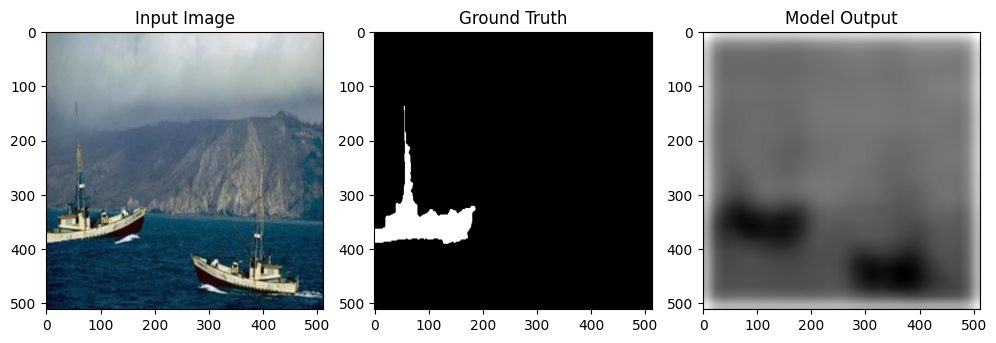

Epoch [2/10], Loss: 0.4828


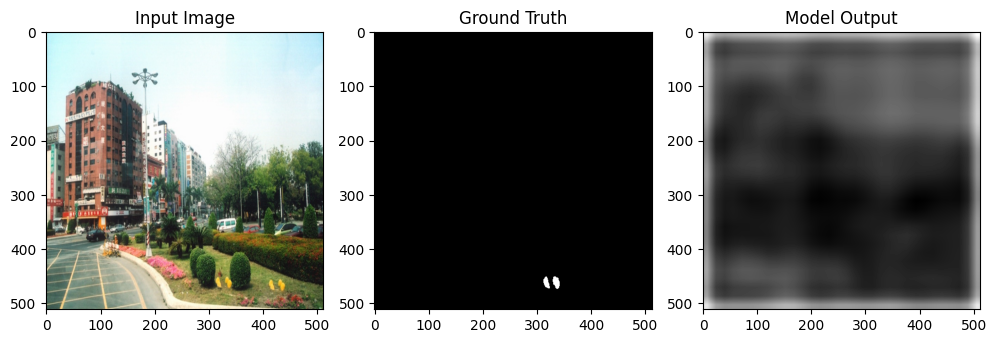

Epoch [3/10], Loss: 0.5033


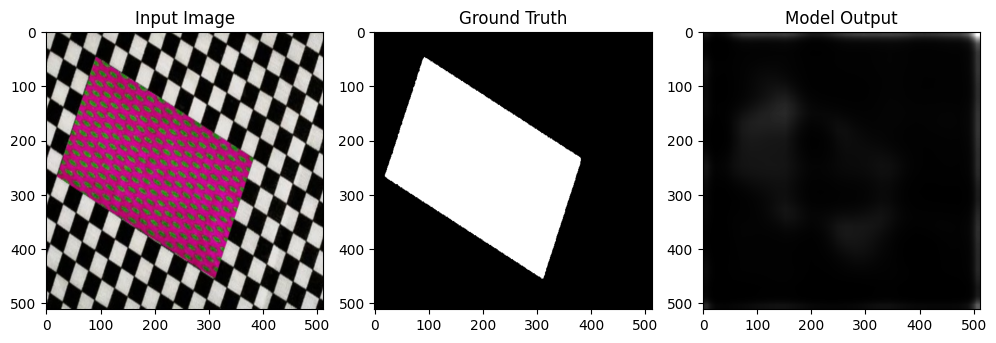

Epoch [4/10], Loss: 0.3981


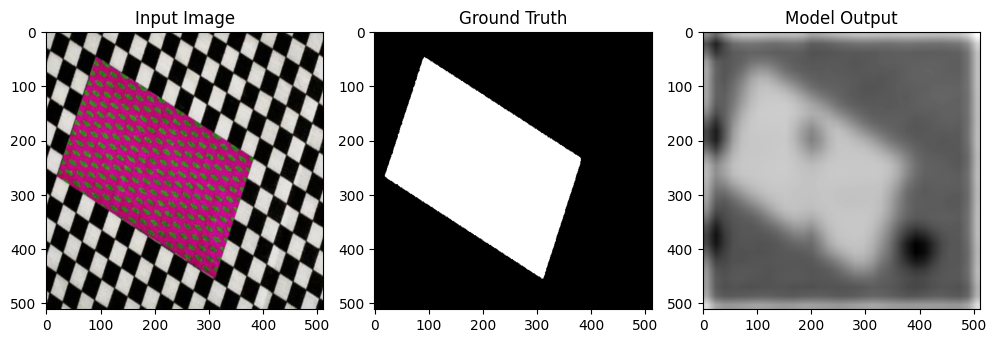

Epoch [5/10], Loss: 0.3344


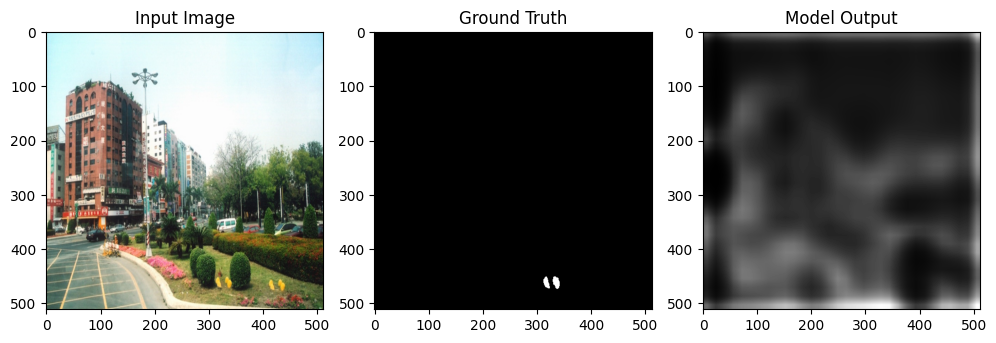

Epoch [6/10], Loss: 0.2349


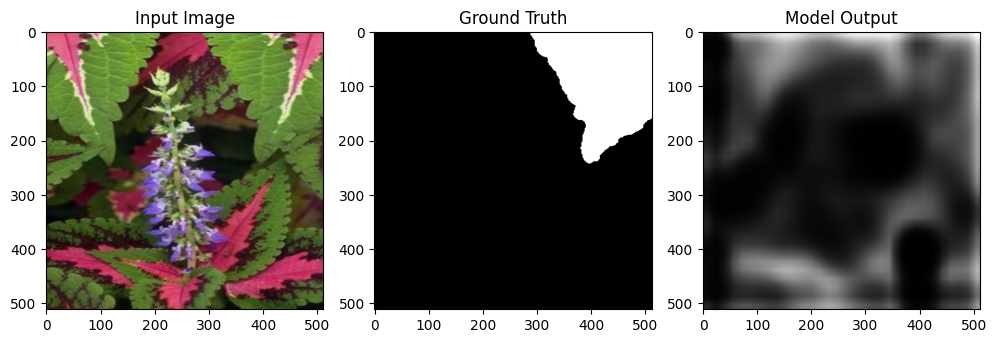

Epoch [7/10], Loss: 0.1911


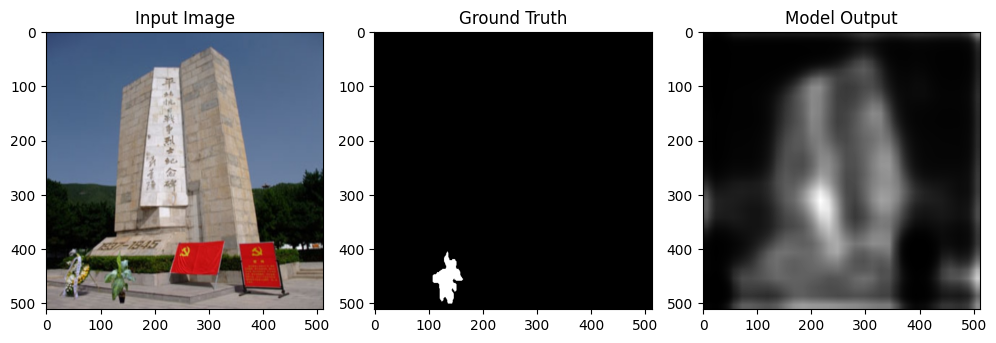

Epoch [8/10], Loss: 0.1549


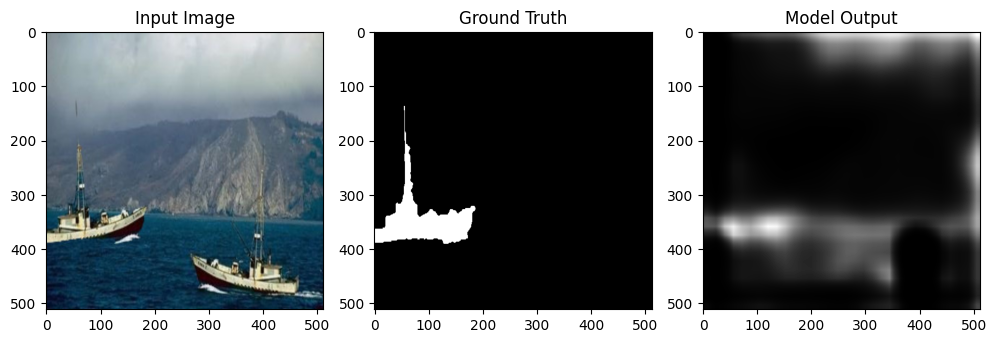

Epoch [9/10], Loss: 0.1430


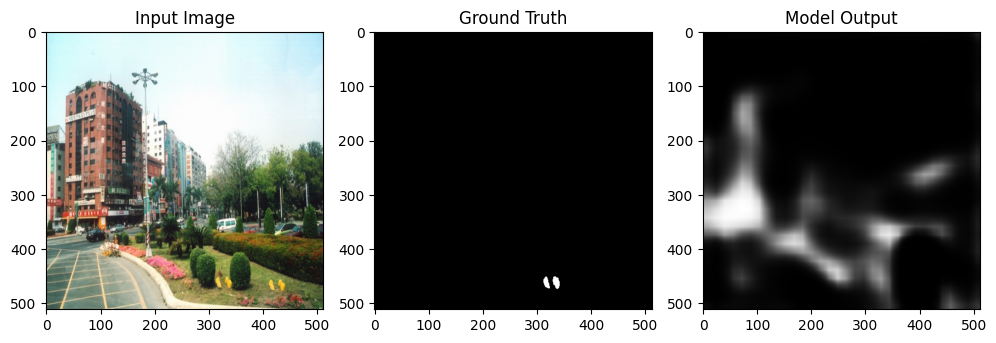

Epoch [10/10], Loss: 0.1160


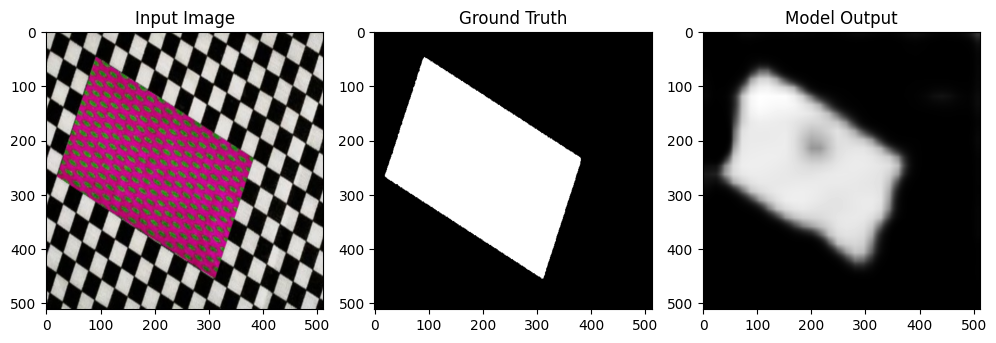

In [24]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt

# ASPP Module
class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ASPP, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, dilation=12, padding=12)
        self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=3, dilation=24, padding=24)
        self.conv4 = nn.Conv2d(in_channels, out_channels, kernel_size=3, dilation=36, padding=36)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.conv_pool = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.conv_out = nn.Conv2d(out_channels * 5, out_channels, kernel_size=1)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x)
        x3 = self.conv3(x)
        x4 = self.conv4(x)
        x5 = self.conv_pool(self.pool(x))
        x5 = nn.functional.interpolate(x5, size=x1.size()[2:], mode="bilinear", align_corners=False)
        x_out = self.conv_out(torch.cat([x1, x2, x3, x4, x5], dim=1))
        return x_out

# Feature Recalibration Module
class FeatureRecalibration(nn.Module):
    def __init__(self, channels):
        super(FeatureRecalibration, self).__init__()
        self.channel_weights = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, channels // 2, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(channels // 2, channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        attention = self.channel_weights(x)
        return x * attention

# MFAN Architecture
class MFAN(nn.Module):
    def __init__(self):
        super(MFAN, self).__init__()
        backbone = models.resnet50(pretrained=True)

        # Encoder
        self.enc1 = nn.Sequential(backbone.conv1, backbone.bn1, backbone.relu, backbone.maxpool)
        self.enc2 = backbone.layer1
        self.enc3 = backbone.layer2
        self.enc4 = backbone.layer3

        # ASPP
        self.aspp = ASPP(1024, 256)

        # Feature Fusion
        self.fuse = nn.Conv2d(256 + 256 + 64, 256, kernel_size=1)

        # Feature Recalibration
        self.recalibration = FeatureRecalibration(256)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 1, kernel_size=1),
            nn.Upsample(size=(512, 512), mode='bilinear', align_corners=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)

        # ASPP
        aspp_out = self.aspp(enc4)

        # Resize for compatibility
        enc2_resized = nn.functional.interpolate(enc2, size=aspp_out.size()[2:], mode="bilinear", align_corners=False)
        enc1_resized = nn.functional.interpolate(enc1, size=aspp_out.size()[2:], mode="bilinear", align_corners=False)

        # Fuse Features
        fused = self.fuse(torch.cat([aspp_out, enc2_resized, enc1_resized], dim=1))

        # Feature Recalibration
        recalibrated = self.recalibration(fused)

        # Decoder
        output = self.decoder(recalibrated)
        return output

# Dataset class
class TamperDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        tampered_image_path = self.dataframe.iloc[idx]['tampered_image_file_path']
        groundtruth_image_path = self.dataframe.iloc[idx]['groundtruth_image_file_path']

        tampered_image = Image.open(tampered_image_path).convert("RGB")
        groundtruth_image = Image.open(groundtruth_image_path).convert("L")

        if self.transform:
            tampered_image = self.transform(tampered_image)
            groundtruth_image = self.transform(groundtruth_image)

        return tampered_image, groundtruth_image

# Loss Function
class MFANLoss(nn.Module):
    def __init__(self, alpha=0.2):
        super(MFANLoss, self).__init__()
        self.alpha = alpha
        self.bce_loss = nn.BCELoss()

    def forward(self, output, target):
        return self.bce_loss(output, target)

def visualize_results(inputs, targets, outputs):
    plt.figure(figsize=(10, 5))

    # Input image (convert tensor to numpy and permute for correct channel order)
    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(inputs[0].cpu().permute(1, 2, 0).numpy())

    # Ground truth mask (squeeze to remove extra dimension)
    plt.subplot(1, 3, 2)
    plt.title("Ground Truth")
    plt.imshow(targets[0].cpu().squeeze().numpy(), cmap='gray')

    # Model output (detach, move to CPU, squeeze, and convert to numpy)
    plt.subplot(1, 3, 3)
    plt.title("Model Output")
    plt.imshow(outputs[0].detach().cpu().squeeze().numpy(), cmap='gray')

    plt.tight_layout()
    plt.show()

# Load Data (Replace with actual DataFrame)
# import pandas as pd
# data = {
#     'tampered_image_file_path': ['./example_image_1.jpg'],  # Replace with actual paths
#     'groundtruth_image_file_path': ['./example_groundtruth_1.png']  # Replace with actual paths
# }
train_data = train_data.head(5)

# Transforms
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

# DataLoader
train_dataset = TamperDataset(train_data, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

# Model Initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MFAN().to(device)

# Training
num_epochs = 10
criterion = MFANLoss()
optimizer = Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# Initialize lists to track metrics
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    # Training
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, targets)
        epoch_loss += loss.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        preds = (outputs > 0.5).float()
        correct += (preds == targets).sum().item()
        total += targets.numel()

    train_loss = epoch_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    scheduler.step(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.4f}")

    # Visualize after each epoch
    visualize_results(inputs, targets, outputs)


In [25]:
test_data=test_data.head(10)

# Apply the same transforms as the training data
test_dataset = TamperDataset(test_data, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [26]:
def evaluate_model(model, dataloader, device):
    model.eval()
    iou_scores = []
    f1_scores = []
    test_losses = []
    test_accuracies = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Predict
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_losses.append(loss.item())

            # Threshold outputs to binary (0 or 1)
            preds = (outputs > 0.5).float()

            # Calculate IoU
            intersection = (preds * targets).sum()
            union = (preds + targets).sum() - intersection
            iou = intersection / (union + 1e-6)  # Avoid division by zero
            iou_scores.append(iou.item())

            # Calculate F1 Score
            tp = (preds * targets).sum()  # True positives
            fp = (preds * (1 - targets)).sum()  # False positives
            fn = ((1 - preds) * targets).sum()  # False negatives
            precision = tp / (tp + fp + 1e-6)
            recall = tp / (tp + fn + 1e-6)
            f1 = 2 * (precision * recall) / (precision + recall + 1e-6)
            f1_scores.append(f1.item())

            # Calculate accuracy
            correct = (preds == targets).sum().item()
            total = targets.numel()
            accuracy = 100 * correct / total
            test_accuracies.append(accuracy)

            # Visualize results for a few examples
            visualize_results(inputs, targets, preds)

    # Compute average metrics
    mean_iou = sum(iou_scores) / len(iou_scores)
    mean_f1 = sum(f1_scores) / len(f1_scores)

    print(f"Mean IoU: {mean_iou:.4f}, Mean F1 Score: {mean_f1:.4f}")
    return mean_iou, mean_f1, test_losses, test_accuracies, iou_scores, f1_scores


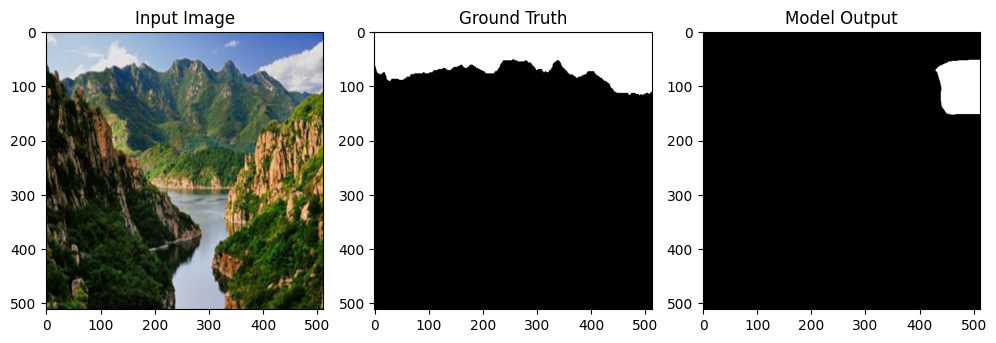

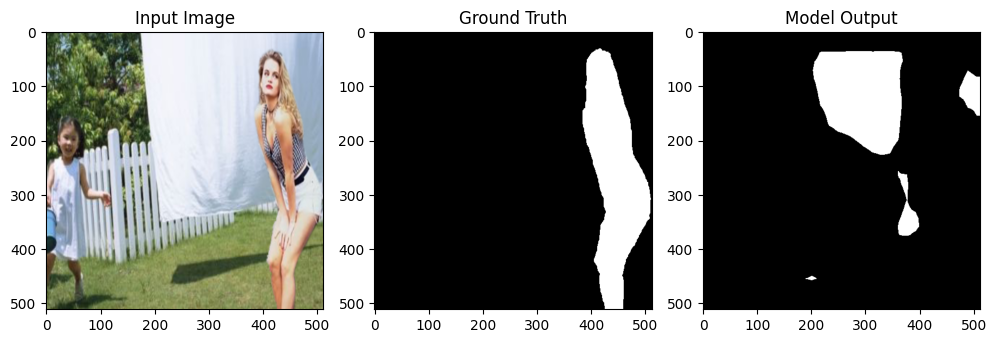

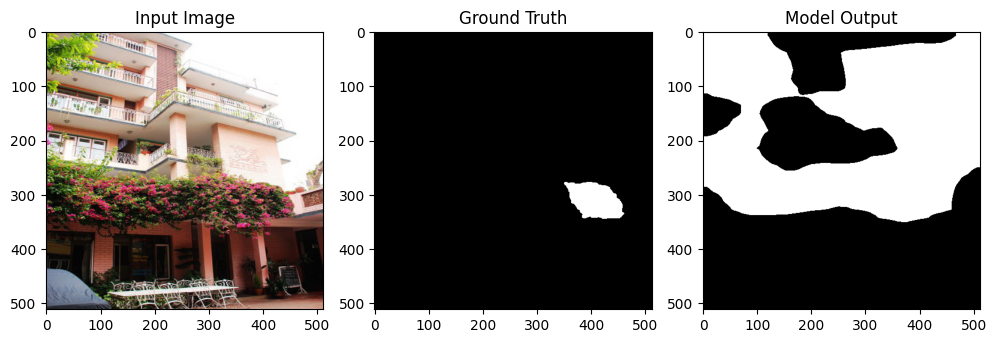

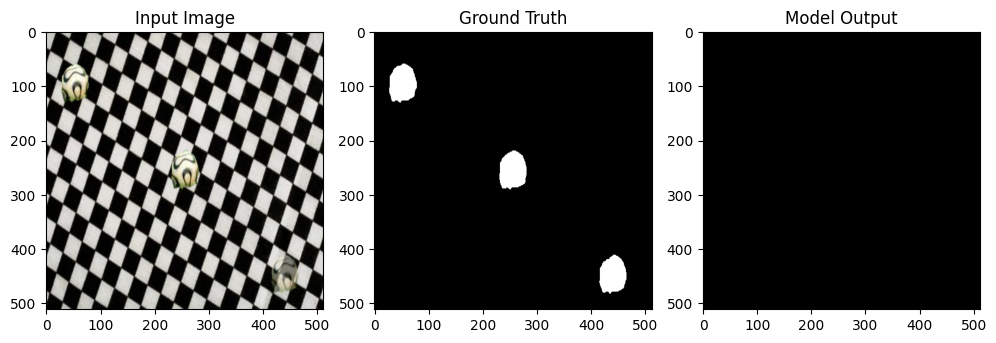

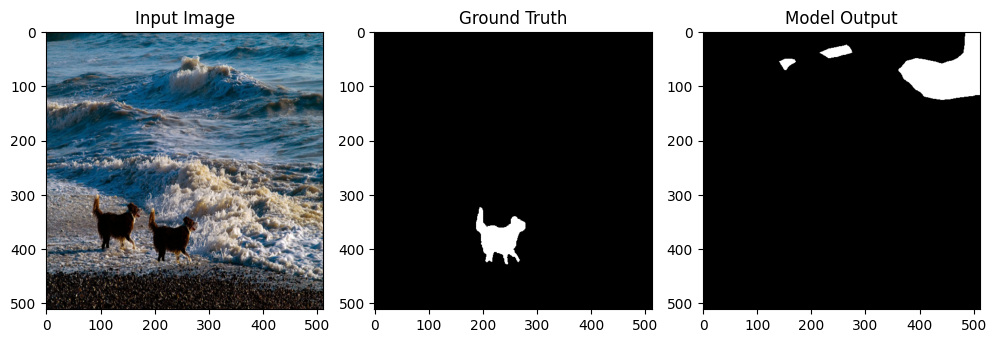

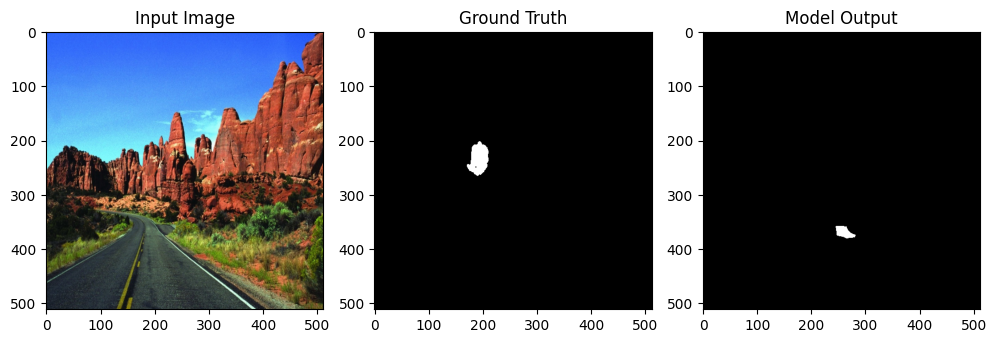

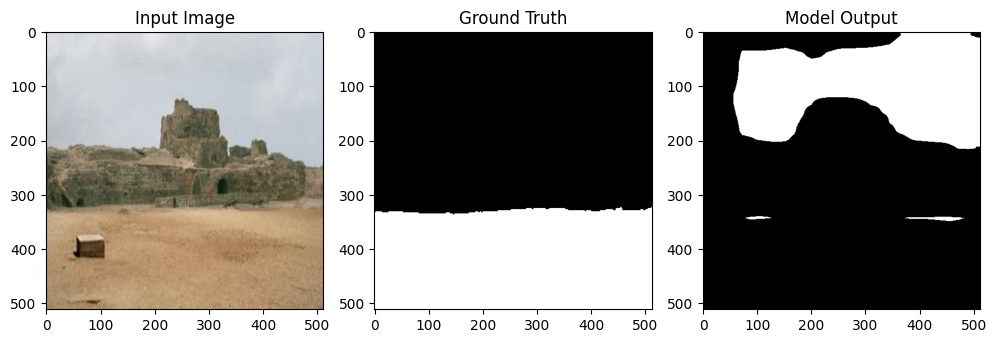

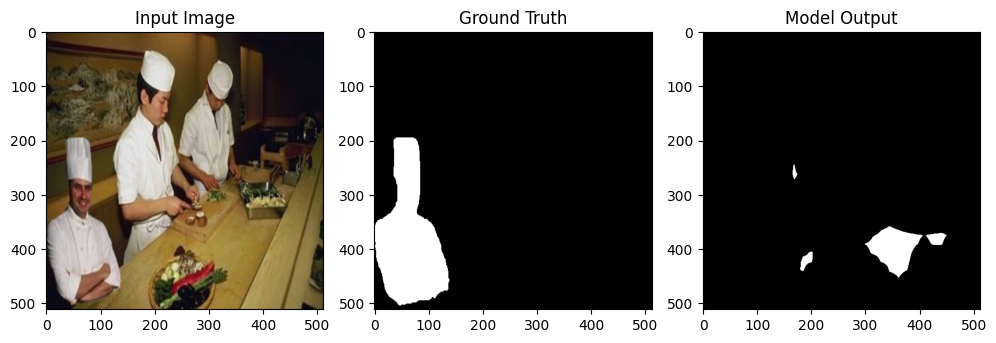

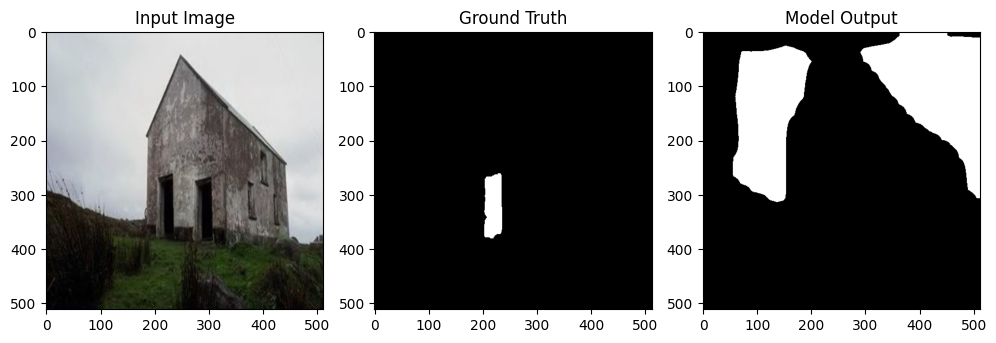

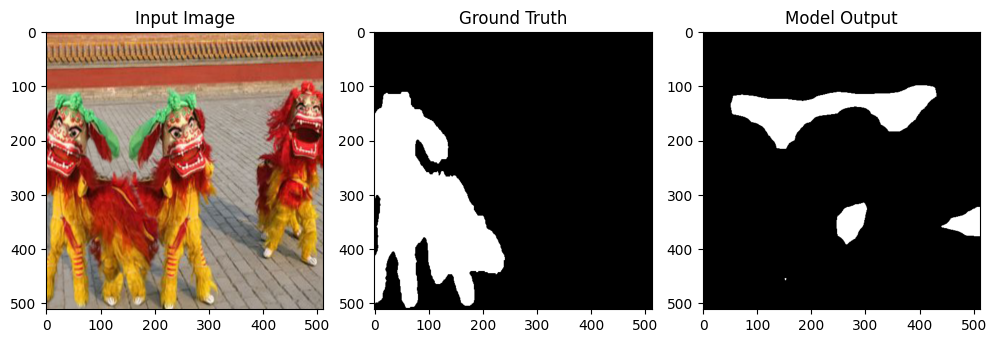

Mean IoU: 0.0166, Mean F1 Score: 0.0309


In [27]:
# Evaluate on test data
mean_iou, mean_f1, test_losses, test_accuracies, iou_scores, f1_scores=evaluate_model(model, test_loader, device)

In [28]:
def plot_iou_f1(iou_scores, f1_scores):
    # Plot IoU Scores for each test sample
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(len(iou_scores)), iou_scores, label='IoU per Sample', color='green')
    plt.xlabel('Sample Index')
    plt.ylabel('IoU')
    plt.title('IoU Scores for Each Test Sample')
    plt.legend()

    # Plot F1 Scores for each test sample
    plt.subplot(1, 2, 2)
    plt.plot(range(len(f1_scores)), f1_scores, label='F1 Score per Sample', color='orange')
    plt.xlabel('Sample Index')
    plt.ylabel('F1 Score')
    plt.title('F1 Scores for Each Test Sample')
    plt.legend()

    plt.tight_layout()
    plt.show()

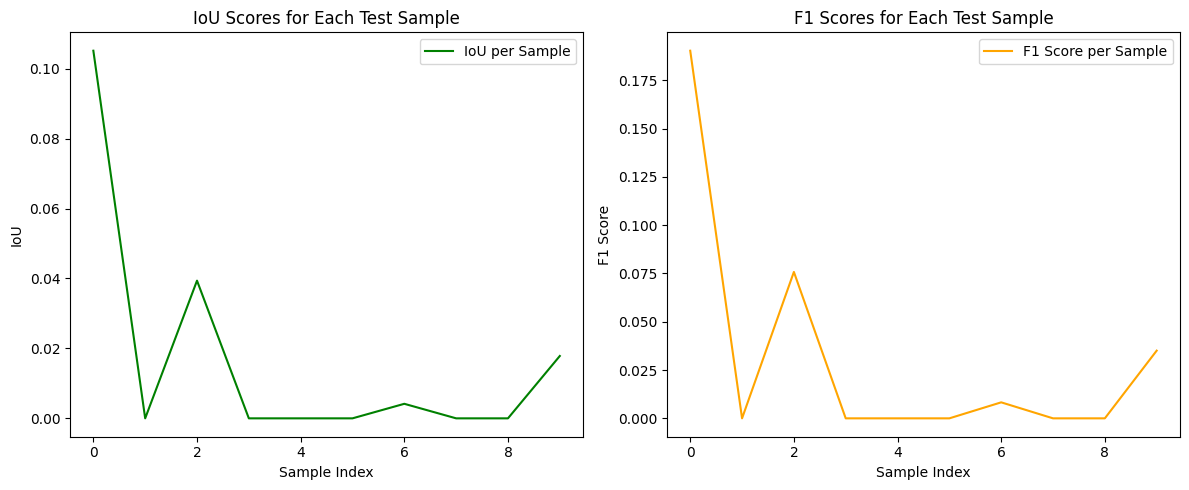

In [29]:
plot_iou_f1(iou_scores, f1_scores)

In [22]:
def plot_metrics(train_losses, train_accuracies, test_losses, test_accuracies):
    epochs = range(1, len(train_losses) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Testing Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, test_accuracies, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Testing Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


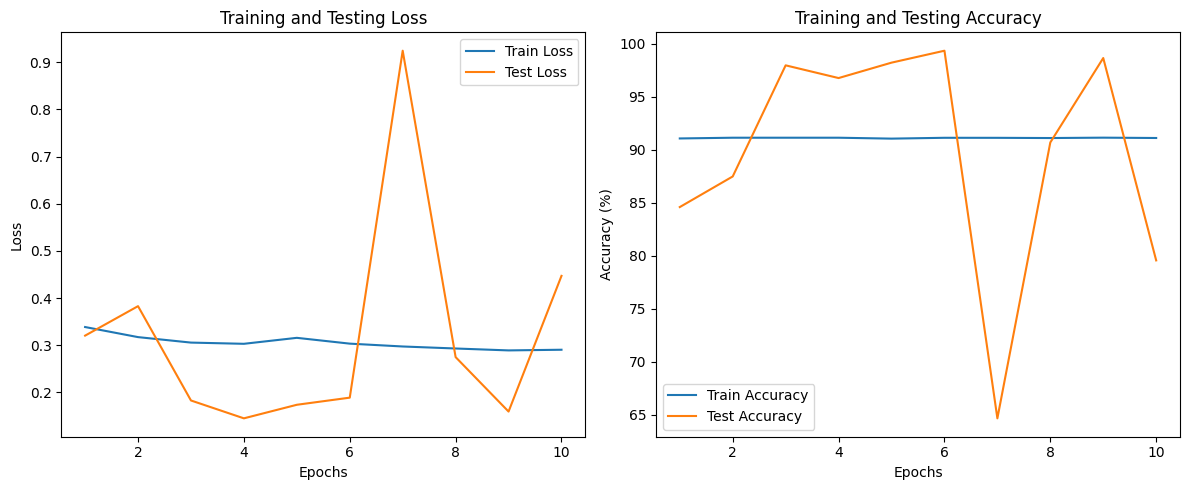

In [23]:
plot_metrics(train_losses, train_accuracies, test_losses, test_accuracies)

In [ ]:
# import torch
# import torch.nn as nn
# import torchvision.models as models
# from torch.optim import Adam
# from torch.optim.lr_scheduler import ReduceLROnPlateau
# import torch.nn.functional as F
# import pandas as pd
# from torch.utils.data import Dataset, DataLoader
# from PIL import Image

# class ASPP(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(ASPP, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
#         self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, dilation=12, padding=12)
#         self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=3, dilation=24, padding=24)
#         self.conv4 = nn.Conv2d(in_channels, out_channels, kernel_size=3, dilation=36, padding=36)
#         self.pool = nn.AdaptiveAvgPool2d(1)
#         self.conv_pool = nn.Conv2d(in_channels, out_channels, kernel_size=1)
#         self.conv_out = nn.Conv2d(out_channels * 5, out_channels, kernel_size=1)

#     def forward(self, x):
#         x1 = self.conv1(x)
#         x2 = self.conv2(x)
#         x3 = self.conv3(x)
#         x4 = self.conv4(x)
#         x5 = self.conv_pool(self.pool(x))
#         x5 = nn.functional.interpolate(x5, size=x1.size()[2:], mode="bilinear", align_corners=False)
#         x_out = self.conv_out(torch.cat([x1, x2, x3, x4, x5], dim=1))
#         return x_out

# class FeatureRecalibration(nn.Module):
#     def __init__(self, channels):
#         super(FeatureRecalibration, self).__init__()
#         self.channel_weights = nn.Sequential(
#             nn.Conv2d(channels, channels // 2, kernel_size=1),
#             nn.ReLU(),
#             nn.Conv2d(channels // 2, channels, kernel_size=1),
#             nn.Softmax(dim=1)
#         )

#     def forward(self, x):
#         attention = self.channel_weights(x)
#         return x * attention

# class MFAN(nn.Module):
#     def __init__(self):
#         super(MFAN, self).__init__()
#         backbone = models.resnet50(pretrained=True)

#         # Encoder
#         self.enc1 = nn.Sequential(backbone.conv1, backbone.bn1, backbone.relu, backbone.maxpool)
#         self.enc2 = backbone.layer1
#         self.enc3 = backbone.layer2
#         self.enc4 = backbone.layer3

#         # ASPP
#         self.aspp = ASPP(1024, 256)

#         # Feature Fusion
#         self.fuse = nn.Conv2d(256 + 256 + 64, 256, kernel_size=1)

#         # Feature Recalibration
#         self.recalibration = FeatureRecalibration(256)

#         # Decoder
#         self.decoder = nn.Sequential(
#             nn.Conv2d(256, 512, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(512, 512, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(512, 1, kernel_size=1),
#             nn.Upsample(size=(512, 512), mode='bilinear', align_corners=False),
#             nn.Sigmoid()  # Ensure output is in range [0, 1]
#         )

#     def forward(self, x):
#         # Encoder
#         enc1 = self.enc1(x)
#         enc2 = self.enc2(enc1)
#         enc3 = self.enc3(enc2)
#         enc4 = self.enc4(enc3)

#         # ASPP
#         aspp_out = self.aspp(enc4)

#         # Resize for compatibility
#         enc2_resized = nn.functional.interpolate(enc2, size=aspp_out.size()[2:], mode="bilinear", align_corners=False)
#         enc1_resized = nn.functional.interpolate(enc1, size=aspp_out.size()[2:], mode="bilinear", align_corners=False)

#         # Fuse Features
#         fused = self.fuse(torch.cat([aspp_out, enc2_resized, enc1_resized], dim=1))

#         # Feature Recalibration
#         recalibrated = self.recalibration(fused)

#         # Decoder
#         output = self.decoder(recalibrated)
#         return output

# # Dataset class
# class TamperDataset(Dataset):
#     def __init__(self, dataframe, transform=None):
#         self.dataframe = dataframe
#         self.transform = transform

#     def __len__(self):
#         return len(self.dataframe)

#     def __getitem__(self, idx):
#         tampered_image_path = self.dataframe.iloc[idx]['tampered_image_file_path']
#         groundtruth_image_path = self.dataframe.iloc[idx]['groundtruth_image_file_path']

#         tampered_image = Image.open(tampered_image_path).convert("RGB")
#         groundtruth_image = Image.open(groundtruth_image_path).convert("L")

#         if self.transform:
#             tampered_image = self.transform(tampered_image)
#             groundtruth_image = self.transform(groundtruth_image)

#         return tampered_image, groundtruth_image

# # # Load train_data DataFrame
# # train_data = pd.read_csv("train_data.csv")

# # # Use first 5 rows of training data
# train_data = train_data.head(500)

# # Transforms
# from torchvision import transforms
# transform = transforms.Compose([
#     transforms.Resize((512, 512)),
#     transforms.ToTensor()
# ])

# # Create DataLoader
# train_dataset = TamperDataset(train_data, transform=transform)
# train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

# # Instantiate the model
# model = MFAN()
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)

# # Define loss functions
# class MFANLoss(nn.Module):
#     def __init__(self, alpha=0.2):
#         super(MFANLoss, self).__init__()
#         self.alpha = alpha
#         self.bce_loss = nn.BCELoss()

#     def forward(self, output, target, aux_output):
#         loc_loss = self.bce_loss(output, target)
#         aux_loss = self.bce_loss(aux_output, target)
#         total_loss = loc_loss + self.alpha * aux_loss
#         return total_loss

# # Optimizer and scheduler
# optimizer = Adam(model.parameters(), lr=0.01)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# # Training loop
# num_epochs = 50
# criterion = MFANLoss()

# model.train()
# for epoch in range(num_epochs):
#     epoch_loss = 0
#     correct = 0
#     total = 0
#     for inputs, targets in train_loader:
#         inputs, targets = inputs.to(device), targets.to(device)

#         # Forward pass
#         outputs = model(inputs)

#         # Compute loss
#         loss = criterion(outputs, targets, outputs)  # Fix loss computation to use correct outputs

#         # Backward pass and optimization
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         epoch_loss += loss.item()

#         # Calculate accuracy
#         predicted = (outputs > 0.5).float()
#         correct += (predicted == targets).sum().item()
#         total += targets.numel()

#     # Step scheduler
#     scheduler.step(epoch_loss)
#     accuracy = 100 * correct / total
#     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.4f}, Accuracy: {accuracy:.2f}%")


In [ ]:
# import numpy as np

# # Testing loop
# # Load test_data DataFrame
# # test_data = pd.read_csv("test_data.csv")
# # test_data = test_data.head(5)

# # Create DataLoader for test data
# test_dataset = TamperDataset(test_data, transform=transform)
# test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# # Evaluation Metrics
# def calculate_iou(pred, target):
#     intersection = np.logical_and(pred, target).sum()
#     union = np.logical_or(pred, target).sum()
#     iou = intersection / union if union != 0 else 0
#     return iou

# def calculate_f1(pred, target):
#     tp = np.logical_and(pred == 1, target == 1).sum()
#     fp = np.logical_and(pred == 1, target == 0).sum()
#     fn = np.logical_and(pred == 0, target == 1).sum()
#     precision = tp / (tp + fp) if (tp + fp) != 0 else 0
#     recall = tp / (tp + fn) if (tp + fn) != 0 else 0
#     f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
#     return f1, precision, recall

# # Testing and evaluation
# model.eval()
# iou_scores = []
# f1_scores = []
# precision_scores = []
# accuracy_scores = []
# output_dir = "predictions"
# os.makedirs(output_dir, exist_ok=True)
# with torch.no_grad():
#     for idx, (test_inputs, test_targets) in enumerate(test_loader):
#         test_inputs, test_targets = test_inputs.to(device), test_targets.to(device)

#         # Forward pass
#         test_outputs = model(test_inputs)

#         # Save predictions
#         for i in range(test_outputs.size(0)):
#             prediction = test_outputs[i].cpu().squeeze().numpy()
#             prediction_image = Image.fromarray((prediction * 255).astype('uint8'))
#             prediction_image.save(os.path.join(output_dir, f"prediction_{idx * test_outputs.size(0) + i}.png"))

#             # Calculate IoU, F1 score, precision, and accuracy
#             target = test_targets[i].cpu().squeeze().numpy()
#             pred_binary = prediction > 0.5
#             target_binary = target > 0.5

#             iou = calculate_iou(pred_binary, target_binary)
#             f1, precision, recall = calculate_f1(pred_binary, target_binary)
#             accuracy = (pred_binary == target_binary).sum() / target_binary.size

#             iou_scores.append(iou)
#             f1_scores.append(f1)
#             precision_scores.append(precision)
#             accuracy_scores.append(accuracy)

#             # Print individual accuracy
#             print(f"Accuracy for sample {idx * test_outputs.size(0) + i}: {accuracy:.4f}")

# # Print evaluation results
# mean_iou = np.mean(iou_scores)
# mean_f1 = np.mean(f1_scores)
# mean_precision = np.mean(precision_scores)
# mean_accuracy = np.mean(accuracy_scores)
# print(f"Mean IoU: {mean_iou:.4f}")
# print(f"Mean F1 Score: {mean_f1:.4f}")
# print(f"Mean Precision: {mean_precision:.4f}")
# print(f"Mean Accuracy: {mean_accuracy:.4f}")
